Diego Toribio  
Professor Eilin Perez  
SS-322: History and Visuality  
Final Project

In [78]:
import ee
import geemap
from IPython.display import Image, HTML
from collections import OrderedDict

# Authenticate & initialize
ee.Authenticate()
ee.Initialize(project='toribiodiego-ece471')

### Load & Display Monterrey Boundary

Here we load the geoBoundaries ADM2 collection, filter to Monterrey, and display it on a map centered slightly south of the city.

In [64]:
# load and filter geoBoundaries for Monterrey
monterrey_geob = ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2') \
    .filter(ee.Filter.And(
        ee.Filter.eq('shapeGroup', 'MEX'),
        ee.Filter.eq('shapeName', 'Monterrey')
    ))

# center map slightly south of city
lat, lon = 25.6866, -100.3161
m = geemap.Map(center=[lat - 0.05, lon], zoom=11)

# display the red boundary
m.addLayer(
    monterrey_geob,
    {'color': 'red', 'fillColor': '00000000', 'width': 3},
    'monterrey boundary'
)
m.addLayerControl()
m

Map(center=[25.636599999999998, -100.3161], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

### ΔNDBI Growth Map

We calculate the Normalized Difference Built-up Index (NDBI) for two years (2003 and 2013) using the appropriate Landsat collection and bands, then subtract to get ΔNDBI. Masking out values below 0.05 highlights significant built-up expansion. Finally, we overlay this growth layer on the Monterrey municipal outline for spatial context.

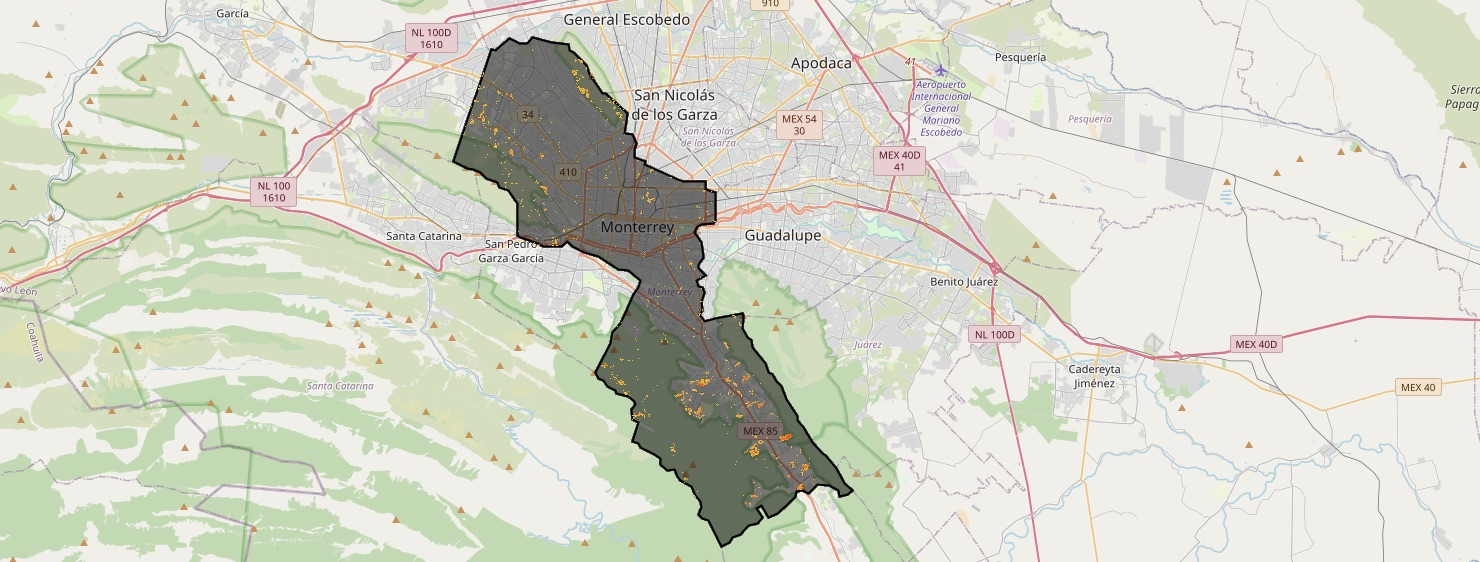

In [38]:
# load and filter Monterrey boundary
boundary_fc = (
    ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2')
      .filter(ee.Filter.And(
          ee.Filter.eq('shapeGroup', 'MEX'),
          ee.Filter.eq('shapeName', 'Monterrey')
      ))
)

# compute annual NDBI
def ndbi_year(year):
    coll = 'LANDSAT/LE07/C02/T1_L2' if year < 2013 else 'LANDSAT/LC08/C02/T1_L2'
    nir, swir = ('SR_B4','SR_B5') if year < 2013 else ('SR_B5','SR_B6')
    return (
        ee.ImageCollection(coll)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filterBounds(boundary_fc.geometry())
          .median()
          .clip(boundary_fc.geometry())
          .normalizedDifference([swir, nir])
          .rename('NDBI')
    )

ndbi03 = ndbi_year(2003)
ndbi13 = ndbi_year(2013)
growth = ndbi13.subtract(ndbi03).rename('ΔNDBI')

# visualization parameters
vis_growth = {
    'min': 0,
    'max': 0.3,
    'palette': ['#f0ff1e', '#f78d08', '#f71d06', '#110cff']
}

# display outline and growth
m = geemap.Map(center=[25.635, -100.3161], zoom=11)
m.addLayer(
    boundary_fc,
    {'color': 'black', 'fillColor': '#00000000', 'width': 2, 'fillOpacity': 0},
    'Monterrey Outline'
)
m.addLayer(
    growth.updateMask(growth.gt(0.05)),
    vis_growth,
    'Growth 2003 → 2013'
)
m.addLayerControl()
m

Image(filename='growth_map.jpeg')

#### Helper Functions

In [132]:
# compute median NDBI for a year
def compute_ndbi_year(boundary_fc, year):
    coll = 'LANDSAT/LE07/C02/T1_L2' if year < 2013 else 'LANDSAT/LC08/C02/T1_L2'
    nir, swir = ('SR_B4','SR_B5') if year < 2013 else ('SR_B5','SR_B6')
    img = (ee.ImageCollection(coll)
           .filterDate(f'{year}-01-01', f'{year}-12-31')
           .filterBounds(boundary_fc.geometry())
           .median()
           .clip(boundary_fc.geometry()))
    return img.normalizedDifference([swir, nir]).rename('NDBI')

# generate ΔNDBI frames (per-interval or cumulative)
def compute_growth_frames(boundary_fc, start_year, end_year,
                          interval=5, threshold=0.05, vis_params=None,
                          boundary_color='ffffff', boundary_width=2,
                          cumulative=False):
    if vis_params is None:
        vis_params = {'min':0,'max':0.3,
                      'palette':['#f0ff1e','#f78d08','#f71d06','#110cff']}
    # prepare boundary overlay
    b_img = ee.Image().byte().paint(boundary_fc, 1, boundary_width)
    b_rgb = b_img.visualize(palette=[boundary_color], forceRgbOutput=True)
    frames = OrderedDict()
    years = list(range(start_year, end_year+1, interval))
    if cumulative:
        cum = ee.Image(0).rename('ΔNDBI').clip(boundary_fc.geometry())
        # baseline frame
        base = cum.updateMask(cum.gt(0)).set('system:time_start',
                 ee.Date.fromYMD(start_year,1,1).millis())
        frames[start_year] = base.visualize(**vis_params) \
                                  .blend(b_rgb) \
                                  .set('system:time_start', base.get('system:time_start'))
        for e in years[1:]:
            prev = e-interval
            delta = compute_ndbi_year(boundary_fc, e) \
                    .subtract(compute_ndbi_year(boundary_fc, prev))
            delta_masked = delta.where(delta.lt(threshold), 0)
            cum = cum.add(delta_masked)
            pos = cum.updateMask(cum.gt(0)) \
                     .set('system:time_start', ee.Date.fromYMD(e,1,1).millis())
            frames[e] = pos.visualize(**vis_params) \
                            .blend(b_rgb) \
                            .set('system:time_start', pos.get('system:time_start'))
    else:
        for s in years[:-1]:
            e = s+interval
            diff = compute_ndbi_year(boundary_fc, e) \
                   .subtract(compute_ndbi_year(boundary_fc, s))
            diff_masked = diff.updateMask(diff.gt(threshold)) \
                             .set('system:time_start', ee.Date.fromYMD(e,1,1).millis())
            frames[e] = diff_masked.visualize(**vis_params) \
                                   .blend(b_rgb) \
                                   .set('system:time_start', diff_masked.get('system:time_start'))
    return frames

# create GIF url from frames
def make_gif_url(frames_dict, region, fps=1, dimensions=600):
    imgs = list(frames_dict.values())
    ic = ee.ImageCollection(imgs).select(['vis-red','vis-green','vis-blue'])
    return ic.getVideoThumbURL({
        'framesPerSecond': fps,
        'dimensions':     dimensions,
        'region':         region,
        'format':         'gif'
    })

# render gif with animated year label
def get_gif(frames_dict, gif_url, fps=1, dimensions=600,
            title="Urban Growth (ΔNDBI)", max_width=600, lag_frames=2):
    years = list(frames_dict.keys())
    n = len(years)
    duration = n / fps
    # build keyframes
    kf = "\n".join([f"  {(i/n)*100:.2f}% {{ content: '{yr}'; }}"
                    for i, yr in enumerate(years)])
    html = f"""
<div style="text-align:center; margin-top:20px;">
  <h3>{title}</h3>
  <div style="position:relative; display:inline-block; max-width:{max_width}px; width:100%;">
    <img src="{gif_url}" style="width:100%; height:auto;" alt="ΔNDBI GIF"/>
    <div class="yearLabel" style="
          position:absolute; top:8px; right:12px;
          font-family:sans-serif; font-size:20px; font-weight:bold;
          color:#ffffff; text-shadow:1px 1px 3px rgba(0,0,0,0.7);
    "></div>
  </div>
</div>
<style>
@keyframes yearAnim {{
{kf}
}}
.yearLabel::after {{
  content: '{years[0]}';
  animation: yearAnim {duration}s steps({n}) infinite;
  animation-delay: {-lag_frames*(duration/n)}s;
}}
</style>
"""
    return HTML(html)

### 5-Year Cumulative ΔNDBI GIF (2000–2025)

compute cumulative ΔNDBI frames over 5-year intervals, build gif url, and render with shifted year label.


In [124]:
# define Monterrey boundary
boundary_fc = (ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2')
    .filter(ee.Filter.And(
        ee.Filter.eq('shapeGroup','MEX'),
        ee.Filter.eq('shapeName','Monterrey')
    )))

# compute cumulative frames every 5 years
frames_dict = compute_growth_frames(
    boundary_fc=boundary_fc,
    start_year=2000,
    end_year=2025,
    interval=5,
    cumulative=True
)

# build gif url
gif_url = make_gif_url(
    frames_dict,
    region=boundary_fc.geometry(),
    fps=1,
    dimensions=600
)

# display animated gif with label advanced by one frame
display(get_gif(
    frames_dict,
    gif_url,
    fps=1,
    dimensions=600,
    title="Monterrey 5-Year Cumulative Growth (ΔNDBI): 2000–2025",
    max_width=600,
    lag_frames=-1
))


### Annual Cumulative ΔNDBI GIF (2015–2025)

Compute cumulative annual ΔNDBI frames, build the gif url, and display with a shifted year label.


In [133]:
# compute cumulative annual frames
frames_dict = compute_growth_frames(
    boundary_fc=boundary_fc,
    start_year=2015,
    end_year=2025,
    interval=1,
    threshold=0.05,
    vis_params={'min': 0, 'max': 0.3, 'palette': ['#f0ff1e','#f78d08','#f71d06','#110cff']},
    boundary_color='ffffff',
    boundary_width=2,
    cumulative=True
)

# create gif url
gif_url = make_gif_url(
    frames_dict,
    region=boundary_fc.geometry(),
    fps=1,
    dimensions=600
)

# display animated gif with shifted year label
display(get_gif(
    frames_dict,
    gif_url,
    fps=1,
    dimensions=600,
    title="Monterrey Cumulative Urban Growth (ΔNDBI): 2015–2025",
    max_width=600,
    lag_frames=-2
))



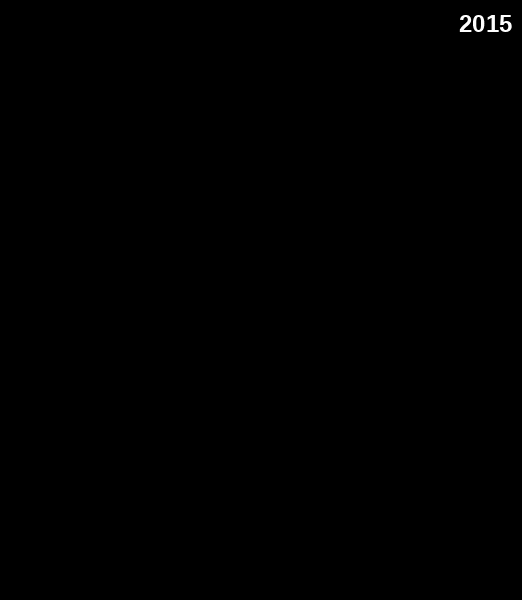

In [143]:
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML
import base64

# regenerate frames
frames_dict = compute_growth_frames(
    boundary_fc, 2015, 2025,
    interval=1, cumulative=True, threshold=0.05,
    vis_params={'min':0,'max':0.3,'palette':['#f0ff1e','#f78d08','#f71d06','#110cff']},
    boundary_color='000000', boundary_width=2
)

# try loading a larger TTF font
font_size = 24
font = None
for path in (
    "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
    "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"
):
    try:
        font = ImageFont.truetype(path, font_size)
        break
    except OSError:
        continue
if font is None:
    font = ImageFont.load_default()

# fetch, annotate, and collect frames
thumb_args = {'dimensions': 600, 'region': boundary_fc.geometry().bounds()}
frames = []
for year, img in frames_dict.items():
    im = Image.open(BytesIO(requests.get(img.getThumbURL(thumb_args)).content)).convert("RGBA")
    draw = ImageDraw.Draw(im)
    txt = str(year)
    w, h = draw.textbbox((0, 0), txt, font=font)[2:]
    x, y = im.width - w - 10, 10
    for dx, dy in [(-2,0),(2,0),(0,-2),(0,2)]:  # thicker halo
        draw.text((x+dx, y+dy), txt, font=font, fill="black")
    draw.text((x, y), txt, font=font, fill="white")
    frames.append(im.convert("P"))

# write to memory & embed inline
buf = BytesIO()
frames[0].save(buf, format="GIF", save_all=True, append_images=frames[1:], duration=1000, loop=0)
b64 = base64.b64encode(buf.getvalue()).decode()

HTML(f"""
<div style="text-align:center; margin-top:20px;">
  <h3>Monterrey Annual Cumulative Growth (ΔNDBI): 2015–2025</h3>
  <img src="data:image/gif;base64,{b64}" style="max-width:600px; width:100%; height:auto;"/>
</div>
""")
